In [3]:
!pip install thop


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report
from thop import profile, clever_format


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Dataset path
DATA_DIR = "/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes"

# ✅ Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Load dataset
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

# ✅ Split 80:20 (Train:Test)
test_ratio = 0.2
test_size = int(test_ratio * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

# ✅ Split 10% of Train as Validation
val_ratio = 0.1
val_size = int(val_ratio * len(train_dataset))
train_size_final = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size_final, val_size])
print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

# ✅ Dataloader setup
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Class names
classes = dataset.classes
num_classes = len(classes)
print(f"Classes: {classes}")



Using device: cuda
Train: 813, Test: 203
Train: 732, Validation: 81, Test: 203
Classes: ['Genus Criconema', 'Genus Criconemoides', 'Genus Helicotylenchus', 'Genus Hemicycliophora', 'Genus Hirschmaniella', 'Genus Hoplolaimus', 'Genus Meloidogyne', 'Genus Pratylenchus', 'Genus Radopholus', 'Genus Trichodorus', 'Genus Xiphinema']


In [6]:
# Load pretrained ViT-B16
vit_model = models.vit_b_16(weights="IMAGENET1K_V1")

# Replace head for our dataset
vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, num_classes)
vit_model = vit_model.to(device)
vit_model.eval()]  # Set evaluation mode initially


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [7]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)
flops, params = profile(vit_model, inputs=(dummy_input,), verbose=False)
flops, params = clever_format([flops, params], "%.3f")
print(f"GFLOPs: {flops}, Parameters: {params}")


GFLOPs: 11.285G, Parameters: 57.307M


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)


In [9]:
num_epochs = 50

for epoch in range(num_epochs):
    vit_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vit_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    vit_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vit_model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/50] Train Loss: 1.7435, Train Acc: 0.4139 | Val Loss: 1.0053, Val Acc: 0.6543
Epoch [2/50] Train Loss: 0.6961, Train Acc: 0.7869 | Val Loss: 0.7060, Val Acc: 0.7901
Epoch [3/50] Train Loss: 0.2376, Train Acc: 0.9426 | Val Loss: 0.7931, Val Acc: 0.7037
Epoch [4/50] Train Loss: 0.1015, Train Acc: 0.9727 | Val Loss: 0.5065, Val Acc: 0.8272
Epoch [5/50] Train Loss: 0.0380, Train Acc: 0.9918 | Val Loss: 0.6618, Val Acc: 0.8272
Epoch [6/50] Train Loss: 0.0247, Train Acc: 0.9945 | Val Loss: 0.4462, Val Acc: 0.8519
Epoch [7/50] Train Loss: 0.0188, Train Acc: 0.9945 | Val Loss: 0.4283, Val Acc: 0.9012
Epoch [8/50] Train Loss: 0.0053, Train Acc: 1.0000 | Val Loss: 0.4313, Val Acc: 0.8889
Epoch [9/50] Train Loss: 0.0030, Train Acc: 1.0000 | Val Loss: 0.4603, Val Acc: 0.8765
Epoch [10/50] Train Loss: 0.0022, Train Acc: 1.0000 | Val Loss: 0.4232, Val Acc: 0.8642
Epoch [11/50] Train Loss: 0.0018, Train Acc: 1.0000 | Val Loss: 0.4125, Val Acc: 0.8642
Epoch [12/50] Train Loss: 0.0016, Train A

In [10]:
all_labels = []
all_probs = []

vit_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = vit_model(images)
        probs = torch.softmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


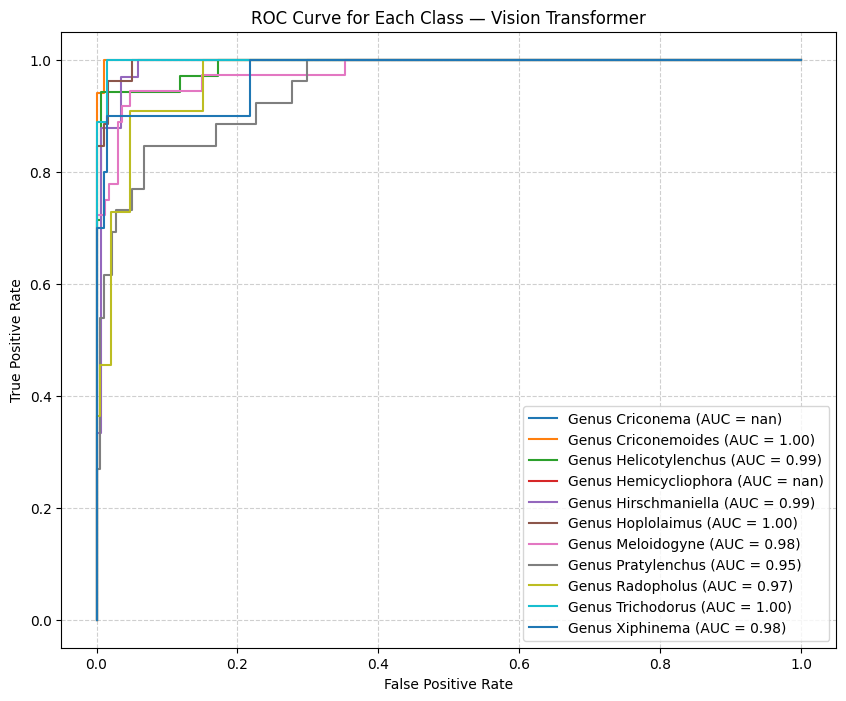

In [11]:
plt.figure(figsize=(10, 8))

for i, cls in enumerate(classes):
    binary_labels = (all_labels == i).astype(int)
    fpr, tpr, _ = roc_curve(binary_labels, all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class — Vision Transformer")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
